In [1]:
from volleyball_analysers import *
import json
import math
import cv2
import numpy as np
import imageio as io
import matplotlib.pyplot as plt


In [2]:
def sample_color(score, min_score=0.5, max_score=1.0):
    """
    Sample a color from a red-to-yellow-to-green palette based on a similarity score.
    
    Args:
        score (float): The similarity score to map to a color. Should be between min_score and max_score.
        min_score (float): The minimum similarity score, mapped to full red.
        max_score (float): The maximum similarity score, mapped to full green.

    Returns:
        tuple: A tuple representing the RGB color.
    """
    # Ensure score is within bounds
    if score < min_score:
        score = min_score
    elif score > max_score:
        score = max_score
    
    # Calculate the normalized score
    normalized_score = (score - min_score) / (max_score - min_score)
    
    if normalized_score <= 0.5:
        # Interpolate from red to yellow
        factor = normalized_score / 0.5
        red = 255
        green = int(factor * 255)
        blue = 0
    else:
        # Interpolate from yellow to green
        factor = (normalized_score - 0.5) / 0.5
        red = int((1 - factor) * 255)
        green = 255
        blue = 0
    
    return (red, green, blue)

def visualize_palette(min_score=0.5, max_score=1.0, num_samples=100):
    """
    Visualize the palette from red to yellow to green.
    
    Args:
        min_score (float): The minimum similarity score.
        max_score (float): The maximum similarity score.
        num_samples (int): The number of samples to generate in the palette.
    """
    scores = np.linspace(min_score, max_score, num_samples)
    colors = [sample_color(score, min_score, max_score) for score in scores]
    
    # Normalize colors to [0, 1] for displaying with matplotlib
    colors = [(r/255, g/255, b/255) for r, g, b in colors]
    
    # Create an image to display the palette
    img = np.array([colors])
    
    plt.figure(figsize=(10, 2))
    plt.imshow(img, aspect='auto')
    plt.title(f'Color Palette from Red to Yellow to Green (Scores {min_score} to {max_score})')
    plt.axis('off')
    plt.show()


def get_colors_per_joint(similarity_per_bp, thresh):
    color_per_joint = np.tile([0, 255, 0], (15, 1))

    '''
    joints order : 
    [nose, neck,
    right_shoulder, right_elbow, right_wrist,
    left_shoulder, left_elbow, left_wrist,
    mid_hip,
    right_hip, right_knee, right_ankle,
    left_hip, left_knee, left_ankle]
    '''
    for bp_idx, bp in enumerate(similarity_per_bp.keys()):
        similarity = round(similarity_per_bp[bp], 2)
        # cur_joint_color_left_side = (255, 255, 0) if similarity > thresh else (255, 0, 0)
        # cur_joint_color_right_side_torso = (0, 255, 0) if similarity > thresh else (255, 0, 0)
        cur_joint_color_left_side = sample_color(similarity, 0.43, 1)
        cur_joint_color_right_side_torso = sample_color(similarity, 0.43, 1)

        if bp == 'torso':
            color_per_joint[[0, 1, 8]] = cur_joint_color_right_side_torso
        elif bp == 'ra':
            color_per_joint[[2, 3, 4]] = cur_joint_color_right_side_torso
        elif bp == 'la':
            color_per_joint[[5, 6, 7]] = cur_joint_color_left_side
        elif bp == 'rl':
            color_per_joint[[9, 10, 11]] = cur_joint_color_right_side_torso
        elif bp == 'll':
            color_per_joint[[12, 13, 14]] = cur_joint_color_left_side
        else:
            raise KeyError('Wrong body part key')
    return color_per_joint


def put_similarity_score_in_video(img, similarity_per_bp, thresh, video_size):
    width, height = video_size
    font_scale = height / 720
    thickness = max(1, int(height / 360))
    for bp_idx, bp in enumerate(similarity_per_bp.keys()):
        similarity = round(similarity_per_bp[bp], 2)
        color = (0, 255, 0) if similarity > thresh else (255, 0, 0)
        y_coord, x_coord = int(0.05 * height + 0.05 * height * bp_idx), int(0.02 * width)
        cv2.putText(img, '{}:{:.2f}'.format(bp, similarity), (x_coord, y_coord), cv2.FONT_HERSHEY_SIMPLEX, font_scale,
                    color, thickness)

def put_filename_in_video(img, filename, video_size):
    width, height = video_size
    font_scale = height / 720
    thickness = max(1, int(height / 360))
    x_coord, y_coord = int(0.15 * width), int(0.05 * height)
    cv2.putText(img, filename, (x_coord, y_coord), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (255, 255, 255), thickness)

def put_phase_in_video(img, phase, video_size, phase_names):
    width, height = video_size
    font_scale = height / 720  # Scale font size based on height (assuming 720p as baseline)
    thickness = max(1, int(height / 360))  # Adjust thickness based on height
    base_y_coord = int(0.05 * height)  # Starting y-coordinate below the filename
    x_coord = int(0.65 * width)  # Set x-coordinate to place text in the top right corner

    for idx, (phase_id, phase_name) in enumerate(phase_names.items()):
        color = (0, 255, 0) if phase_id == phase else (255, 0, 0)  # Green for current phase, red for others
        y_coord = base_y_coord + int(0.05 * height) * idx
        cv2.putText(img, phase_name, (x_coord, y_coord), cv2.FONT_HERSHEY_SIMPLEX, font_scale, color, thickness)



def draw_seq(img, frame_seq, color_per_joint, left_padding=0, is_connected_joints=False):
    assert len(frame_seq) == len(color_per_joint)

    if is_connected_joints:
        draw_connected_joints(img, frame_seq, color_per_joint, left_padding)

    # add joints visualization
    stickwidth = 3
    # stickwidth = 1  # setting for paper
    for joint_idx, joint_xy in enumerate(frame_seq):
        x_coord, y_coord = joint_xy

        # setting for the paper
        # x_coord = x_coord // 5
        # y_coord = y_coord // 2

        color = [int(i) for i in color_per_joint[joint_idx]]
        cv2.circle(img, (left_padding + int(x_coord), int(y_coord)), stickwidth, color, 3)



def draw_connected_joints(canvas, joints, colors, left_padding):
    # connect joints with lines
    # ([nose, neck,
    # right_shoulder, right_elbow, right_wrist,
    # left_shoulder, left_elbow, left_wrist,
    # mid_hip,
    # right_hip, right_knee, right_ankle,
    # left_hip, left_knee, left_ankle,])

    # view from left side -- it was default (left connections were on top of right)
    # limb_seq = [[0, 1], [1, 8], [2, 3], [3, 4], [5, 6], [6, 7], [9, 10], [10, 11], [12, 13], [13, 14]]
    # view from right side -- right side connections are on top of left -- modification
    limb_seq = [[0, 1], [1, 8], [5, 6], [6, 7], [2, 3], [3, 4], [12, 13], [13, 14], [9, 10], [10, 11]]


    stickwidth = 5
    # stickwidth = 1 # setting for paper
    for i in range(len(limb_seq)):
        X = (int(joints[limb_seq[i][0]][0] + left_padding), int(joints[limb_seq[i][1]][0] + left_padding))
        Y = (int(joints[limb_seq[i][0]][1]), int(joints[limb_seq[i][1]][1]))

        mX = np.mean(X)
        mY = np.mean(Y)
        length = ((X[0] - X[1]) ** 2 + (Y[0] - Y[1]) ** 2) ** 0.5
        angle = math.degrees(math.atan2(Y[0] - Y[1], X[0] - X[1]))
        polygon = cv2.ellipse2Poly((int(mX), int(mY)), (int(length / 2), stickwidth), int(angle), 0, 360, 1)
        color = [int(i) for i in colors[limb_seq[i][0]]]
        cv2.fillConvexPoly(canvas, polygon, color)

    return canvas

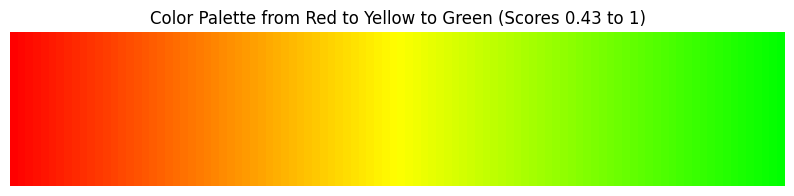

In [3]:
visualize_palette(0.43, 1)

In [4]:
joints = [
    'right_shoulder', 'right_elbow', 'right_wrist', 
    'nose', 
    'left_shoulder', 'left_elbow', 'left_wrist', 
    'right_hip', 'right_knee', 'right_ankle', 
    'left_hip', 'left_knee', 'left_ankle'
    ]

phase_names = {
    0: 'Preparation + Motion Start',
    1: 'Final Steps + Jump Start',
    2: 'Jump Start + Ball Contact',
    3: 'Landing',
}

REFERENCE_DF_PATH = 'attack_pose_data/DATASETS/Techniek_aanval_met_sprong_Ref_POSE_tabel.xlsx'
# COMPARED_DF_PATH = 'attack_pose_data/DATASETS/Techniek_aanval_met_sprong_Ref_POSE_tabel.xlsx'

# Load analysis scripts
mappings = json.load(open('attack_pose_data/translation_mappings.json'))
args = config_parser()
config = Config(args)
similarity_analyzer = SimilarityAnalyzer(config, MODEL_PATH)
mean_pose_bpe = np.load(os.path.join(args.data_dir, 'meanpose_rc_with_view_unit64.npy'))
std_pose_bpe = np.load(os.path.join(args.data_dir, 'stdpose_rc_with_view_unit64.npy'))

In [5]:
# same as in breakpoints analysis
files = ['GX010054_Clip_196_POSE_tabel.xlsx',
        'GX010040_Clip_2_sec_6_POSE_tabel.xlsx',
        'Techniek_aanval_met_sprong_Ref_POSE_tabel.xlsx']

videos = ['GX010054_Clip_196.mp4',
        'GX010040_Clip_2_sec_6.mp4',
        'Techniek_aanval_met_sprong_Ref.mp4']

In [6]:
bkpts_dict = {}

for file, video_name in zip(files, videos):
    result = compare_videos(REFERENCE_DF_PATH, 'attack_pose_data/DATASETS/' + file, 4, joints, config, args, similarity_analyzer, mean_pose_bpe, std_pose_bpe)
    comp_video = 'attack_pose_data/BLURRED_VIDEOS/' + video_name

    video = io.get_reader(comp_video)
    fps = video.get_meta_data()['fps']
    size = video.get_meta_data()['size']
    print(size)

    video = iter(video)

    frame_idx = 0
    sequence, _ = load_pose_data('attack_pose_data/DATASETS/' + file, mappings)
    sequence = preprocess_df_for_bpe(sequence, config)
    bkpts = result[-1]
    bkpts_dict[video_name] = bkpts

    thresh = 0.8
    phase = 0
    all_frames = []
    for frame_idx in range(sequence.shape[2]):

        frame = sequence[:, :, frame_idx]
        canvas = next(video)

        phase_sims = result[1][f'phase_{phase}']
        colors_per_joint = get_colors_per_joint(phase_sims, thresh) 
        
        draw_seq(canvas, frame, colors_per_joint, is_connected_joints=True)

        put_similarity_score_in_video(canvas, phase_sims, thresh, size)
        put_filename_in_video(canvas, comp_video.split('/')[-1], size)
        put_phase_in_video(canvas, phase, size, phase_names)

        if frame_idx in bkpts:
            phase += 1
        all_frames.append(canvas)

    out_path = f'video_outputs/{video_name[:-4]}_incl_scores.mp4'
    io.mimwrite(out_path, all_frames, fps=fps)

(3840, 2160)


[rawvideo @ 0x1537060c0] Stream #0: not enough frames to estimate rate; consider increasing probesize


(3840, 2160)
(1280, 720)


In [7]:
import cv2
import matplotlib.pyplot as plt

def plot_frames(video_path, frame_numbers):
    """
    Plot the specified frames from the video next to each other.
    
    Args:
        video_path (str): Path to the mp4 video file.
        frame_numbers (list): List of frame numbers to plot.
    """
    # Try to open the video file
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        print(f"Error: Cannot open video file {video_path}")
        return
    
    frames = []
    for frame_number in frame_numbers:
        # Set the video capture to the specific frame
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
        
        # Read the frame
        ret, frame = cap.read()
        if not ret:
            print(f"Frame {frame_number} could not be read")
            continue
        
        # Convert the frame from BGR to RGB (OpenCV loads images in BGR format)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)
    
    cap.release()
    
    # Plot the frames next to each other
    num_frames = len(frames)
    if num_frames == 0:
        print("No frames to display")
        return
    
    fig, axes = plt.subplots(1, num_frames, figsize=(15, 5))
    for ax, frame in zip(axes, frames):
        ax.imshow(frame)
        ax.axis('off')
    
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

# Example usage
video_path = 'video_outputs/Techniek_aanval_met_sprong_Ref.mp4_incl_scores.mp4'
frame_numbers = [52, 60, 67]  # Example frame numbers
plot_frames(video_path, frame_numbers)


Error: Cannot open video file video_outputs/Techniek_aanval_met_sprong_Ref.mp4_incl_scores.mp4


OpenCV: Couldn't read video stream from file "video_outputs/Techniek_aanval_met_sprong_Ref.mp4_incl_scores.mp4"


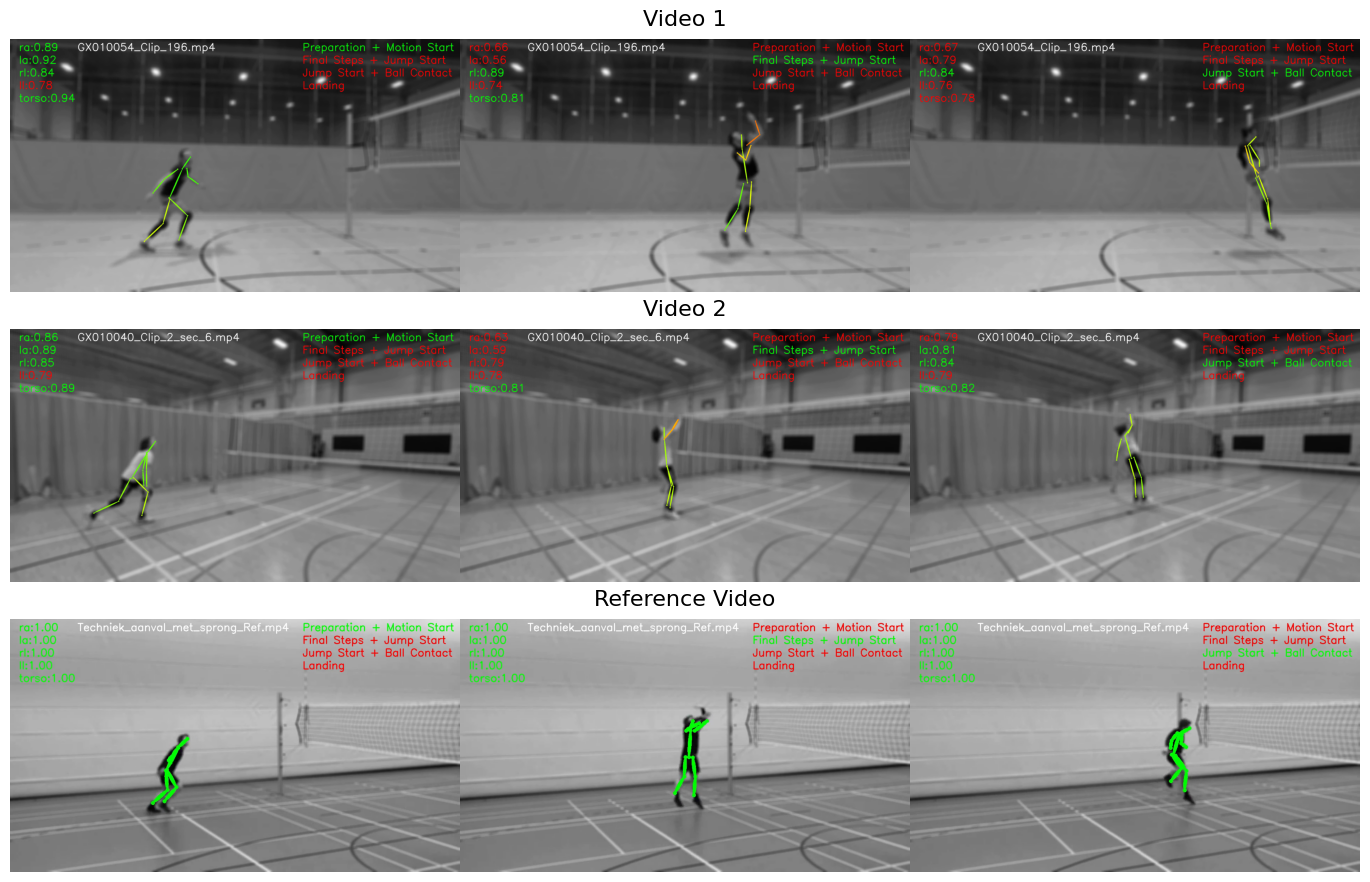

In [8]:
import cv2
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

def get_frames_from_video(video_path, frame_numbers):
    """
    Get frames from the video specified by the frame numbers.
    
    Args:
        video_path (str): Path to the mp4 video file.
        frame_numbers (list): List of frame numbers to get.
    
    Returns:
        list: A list of frames.
    """
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        print(f"Error: Cannot open video file {video_path}")
        return []
    
    frames = []
    for frame_number in frame_numbers:
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
        ret, frame = cap.read()
        if not ret:
            print(f"Frame {frame_number} could not be read from {video_path}")
            continue
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)
    
    cap.release()
    return frames

def plot_frames_from_videos(video_paths, frame_numbers_list, titles):
    """
    Plot frames from multiple videos with custom titles.
    
    Args:
        video_paths (list): List of paths to the mp4 video files.
        frame_numbers_list (list): List of lists of frame numbers for each video.
        titles (list): List of titles for each video.
    """
    num_videos = len(video_paths)
    if num_videos != len(frame_numbers_list) or num_videos != len(titles):
        print("The number of video paths, frame number lists, and titles must be the same.")
        return
    
    fig = plt.figure(figsize=(15, 3.2 * num_videos))
    gs = GridSpec(num_videos, len(frame_numbers_list[0]), figure=fig)
    gs.update(wspace=0, hspace=0.02)  # Reduce space between plots
    
    for i, (video_path, frame_numbers, title) in enumerate(zip(video_paths, frame_numbers_list, titles)):
        frames = get_frames_from_video(video_path, frame_numbers)
        for j, frame in enumerate(frames):
            ax = fig.add_subplot(gs[i, j])
            ax.imshow(frame)
            ax.axis('off')
            if j == 1:
                ax.set_title(title, fontsize=16, pad=10)  # Add padding to title

    # Reduce space between rows
    plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, hspace=0.2)

    plt.show()

# Example usage
video_paths = [
    'video_outputs/GX010054_Clip_196_incl_scores.mp4',
    'video_outputs/GX010040_Clip_2_sec_6_incl_scores.mp4',
    'video_outputs/Techniek_aanval_met_sprong_Ref_incl_scores.mp4'
]
frame_numbers_list = [
    bkpts_dict['GX010054_Clip_196.mp4'],
    bkpts_dict['GX010040_Clip_2_sec_6.mp4'],
    bkpts_dict['Techniek_aanval_met_sprong_Ref.mp4']
]
titles = ['Video 1', 'Video 2', 'Reference Video']

plot_frames_from_videos(video_paths, frame_numbers_list, titles)
